<div style="background: #191970; color: #f0f0f0; padding: 30px; border-radius: 12px; box-shadow: 0 0 30px rgba(0, 224, 255, 0.3); text-align: center; font-family: 'Segoe UI', sans-serif;">
<h1 style="color:#FF00FF; font-size: 2.8em; margin-bottom: 0.2em;">Diabetic Retinopathy Detection using Bayesian ML</h1>
<h2 style="color: #9370DB; font-size: 1.5em;">Classifying Diabetic Retinopathy with Uncertainty-Aware AI</h2>

<h3 style="font-style: italic; color:#87CEFA; font-size: 1.5em;">
"Because sometimes, the model should say 'I don't know'!, its just better for humanity that way !!"
</h3>

<h3 style="margin-top: 30px; font-size: 1.3em;">Team: <span style="background-color: #8B008B; color: white; padding: 4px 12px; border-radius: 8px;">Epochalypse Now</span></h3>

<p style="text-align: center; margin-top: 35px;">
  <span style="background-color: #00e0ff; color: black; padding: 6px 12px; margin: 10px; border-radius: 3px;">Anubuthi</span>
  <span style="background-color: #00e0ff; color: black; padding: 6px 12px; margin: 10px; border-radius: 3px;">Angus</span>
  <span style="background-color: #00e0ff; color: black; padding: 6px 12px; margin: 10px; border-radius: 3px;">Ashwin</span>
  <span style="background-color: #00e0ff; color: black; padding: 6px 12px; margin: 10px; border-radius: 3px;">Gyujin</span>
</p>

<p style="margin-top: 25px; font-size: 1.1em;">
  🔗 <a href="https://github.com/Anubuthi/Epochalypse-Now" target="_blank" style="color: #00e0ff; text-decoration: none;">GitHub Repo</a>&nbsp;|&nbsp;
  <a href="https://www.kaggle.com/code/anubuthikottapalli/bayes-final-epochcolypse-now?scriptVersionId=242230357" target="_blank" style="color: #ffcc00; text-decoration: none;">Kaggle Notebook</a>
</p>
</div>

### 🧠 Abstract

In this project, we present a Bayesian deep learning framework for multi-class classification of diabetic retinopathy (DR) using retinal fundus images, with an emphasis on predictive uncertainty.

We experimented with four model variants:

1. ✅ **ResNet18 with a single Bayesian linear layer**  
2. ✅ **ResNet18 with two stacked Bayesian layers**  
3. ✅ **Custom CNN with one Bayesian layer**  
4. ✅ **Custom CNN with two Bayesian layers**

Each model incorporates **Monte Carlo dropout** and **variational inference** to estimate predictive uncertainty via **entropy**.

We introduce **class-specific entropy thresholds** to allow the model to abstain ("I don't know") when uncertainty is high — with the goal of:
- Reducing **false positives** for early DR stages (0–2)
- Reducing **false negatives** for high-risk stages (3–4)

This uncertainty-aware design leads to more **interpretable, cautious, and clinically aligned predictions**, demonstrating the power of Bayesian modeling in sensitive medical AI applications.

## INSTALLATIONS AND IMPORTS

In [2]:
!pip install blitz-bayesian-pytorch --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 424.4 kB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 26.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.5 MB/s eta 0:00:00:00:0100:01


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms, models
from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## LOADING DATA

### DATA FROM KAGGLE

In [ ]:
!pip install kagglehub --quiet

In [ ]:
import shutil
import random
from pathlib import Path
import os
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ashhhwin/anubu-sota-data")

print("Path to dataset files:", path)
base_path = Path(path)
images_path = base_path /"augmented_images_balanced"
output_path = Path("/content/anu_subset")
!cp -r /root/.cache/kagglehub/datasets/ashhhwin/anubu-sota-data/versions/1 /content/anu_subset

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = ImageFolder('/content/anu_subset/augmented_images_balanced', transform=transform)

In [ ]:
print(dataset.classes)  # ['Healthy', 'Mild DR', 'Moderate DR', 'Proliferate DR', 'Severe DR']
print(dataset.class_to_idx)  # {'Healthy': 0, 'Mild DR': 1, ...}

# DataLoader
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

### USING DATA IN KAGGLE

In [48]:
# Image transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to what your CNN expects
    transforms.ToTensor(),
])

# Load dataset
raw_dataset = ImageFolder(root="/kaggle/input/anubu-sota-data/augmented_images_balanced", transform=transform)

# Check class names and indices
print(raw_dataset.classes)  # ['Healthy', 'Mild DR', 'Moderate DR', 'Proliferate DR', 'Severe DR']
print(raw_dataset.class_to_idx)  # {'Healthy': 0, 'Mild DR': 1, ...}

# DataLoader
dataloader = DataLoader(raw_dataset, batch_size=16, shuffle=True)

['Healthy', 'Mild_DR', 'Moderate_DR', 'Proliferate_DR', 'Severe_DR']
{'Healthy': 0, 'Mild_DR': 1, 'Moderate_DR': 2, 'Proliferate_DR': 3, 'Severe_DR': 4}


## SPLITTING DATA INTO TRAIN AND VALIDATION

In [49]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [50]:
print("Class mapping:", raw_dataset.class_to_idx)

Class mapping: {'Healthy': 0, 'Mild_DR': 1, 'Moderate_DR': 2, 'Proliferate_DR': 3, 'Severe_DR': 4}


In [51]:
from torch.utils.data import random_split, DataLoader
dataset = raw_dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

In [52]:
def count_class_distribution(subset, num_classes=5):
    counts = {i: 0 for i in range(num_classes)}
    for i in range(len(subset)):
        _, label = subset[i]
        counts[label] += 1
    return counts

In [53]:
train_counts = count_class_distribution(train_ds, num_classes=5)
val_counts = count_class_distribution(val_ds, num_classes=5)

print("Train class distribution:")
for k in sorted(train_counts.keys()):
    print(f"  Class {k}: {train_counts[k]}")
print(f"  Total:    {sum(train_counts.values())}")

print("\nValidation class distribution:")
for k in sorted(val_counts.keys()):
    print(f"  Class {k}: {val_counts[k]}")
print(f"  Total:    {sum(val_counts.values())}")

Train class distribution:
  Class 0: 798
  Class 1: 800
  Class 2: 805
  Class 3: 799
  Class 4: 798
  Total:    4000

Validation class distribution:
  Class 0: 203
  Class 1: 200
  Class 2: 195
  Class 3: 201
  Class 4: 202
  Total:    1001


In [54]:
val_total = len(val_ds)
val_tune_size = int(0.7 * val_total)
val_holdout_size = val_total - val_tune_size

val_tune, val_holdout = random_split(val_ds, [val_tune_size, val_holdout_size])
val_tune_loader = DataLoader(val_tune, batch_size=32, shuffle=False)
val_holdout_loader = DataLoader(val_holdout, batch_size=32, shuffle=False)

In [55]:
for _, labels in train_loader:
    print(labels.min().item(), labels.max().item())
    print(labels.dtype)
    break

0 4
torch.int64


## HELPER FUNCTIONS

In [17]:
def enable_mc_dropout(model):
    """Force dropout to be active during inference"""
    for m in model.modules():
        if isinstance(m, nn.Dropout):
            m.train()

In [56]:
def train(model, dataloader, optimizer, epoch, loss_history):
    model.train()
    total_loss = 0

    for i, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        loss = model.sample_elbo(
            inputs=images,
            labels=labels,
            criterion=criterion,
            sample_nbr=3,
            complexity_cost_weight=5e-3  # increase if variances collapse
        )
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch} | Avg Loss: {avg_loss:.4f}")

In [19]:
def predictive_entropy(mean_probs):
    return -torch.sum(mean_probs * torch.log(mean_probs + 1e-8)).item()

In [20]:
def predict_with_uncertainty(model, x, n_samples=30):
    model.eval()
    softmaxes = []

    with torch.no_grad():
        for _ in range(n_samples):
            logits = model(x)
            probs = torch.softmax(logits, dim=1)
            softmaxes.append(probs)

    all_probs = torch.stack(softmaxes)       # shape: [n_samples, 1, 5]
    mean_probs = all_probs.mean(dim=0)[0]    # shape: [5]
    std_probs = all_probs.std(dim=0)[0]      # shape: [5]

    predicted_class = mean_probs.argmax().item()
    uncertainty = predictive_entropy(mean_probs)    # average uncertainty across 5 classes

    return predicted_class, mean_probs, std_probs, uncertainty
def evaluate_model(model, val_loader, max_samples=100):
    model.eval()
    preds, true_labels, uncertainties = [], [], []

    enable_mc_dropout(model)  # keep dropout active during inference
    count = 0

    with torch.no_grad():
        for images, labels in val_loader:
            for img, label in zip(images, labels):
                if max_samples and count >= max_samples:
                    return preds, true_labels, uncertainties

                img = img.unsqueeze(0).to(device)
                label = label.item()

                pred_class, _, _, uncertainty = predict_with_uncertainty(model, img)

                preds.append(pred_class)
                true_labels.append(label)
                uncertainties.append(uncertainty)
                count += 1

    return preds, true_labels, uncertainties

In [101]:
def predict_with_uncertainty_with_threshold(model, x, threshold=0.5, n_samples=30):
    model.eval()
    softmaxes = []

    with torch.no_grad():
        for _ in range(n_samples):
            logits = model(x)  # [1, 5]
            probs = torch.softmax(logits, dim=1)  # [1, 5]
            softmaxes.append(probs)

    all_probs = torch.stack(softmaxes)       # [n_samples, 1, 5]
    mean_probs = all_probs.mean(dim=0)[0]    # [5]
    std_probs = all_probs.std(dim=0)[0]      # [5]

    uncertainty = std_probs.mean().item()    # scalar

    if uncertainty > threshold:
        return "IDK", mean_probs, std_probs, uncertainty
    else:
        predicted_class = mean_probs.argmax().item()
        return predicted_class, mean_probs, std_probs, uncertainty


def get_val_predictions_with_idk_and_images1(model, val_loader, threshold=0.5, max_samples=None):
    preds, true_labels, uncertainties, idk_flags, images_list = [], [], [], [], []

    model.eval()
    enable_mc_dropout(model)  # dropout stays active
    count = 0

    with torch.no_grad():
        for images, labels in val_loader:
            for img, label in zip(images, labels):
                if max_samples and count >= max_samples:
                    return preds, true_labels, uncertainties, idk_flags, images_list

                img_input = img.unsqueeze(0).to(device)
                pred, _, _, uncertainty = predict_with_uncertainty_with_threshold(model, img_input, threshold=threshold)

                preds.append(pred)
                true_labels.append(label.item())
                uncertainties.append(uncertainty)
                idk_flags.append(pred == "IDK")
                images_list.append(img.cpu())

                count += 1

    return preds, true_labels, uncertainties, idk_flags, images_list

In [88]:
def sweep_entropy_threshold_for_class(df, target_class, thresholds=np.linspace(0.1, 1.6, 30)):
    metrics = []

    for thresh in thresholds:
        preds_with_idk = []

        for _, row in df.iterrows():
            pred = row['pred']
            entropy = row['entropy']

            # If predicted class is the target and entropy is too high, say IDK
            if pred == target_class and entropy > thresh:
                pred = "IDK"

            preds_with_idk.append(pred)

        # Build new column
        df['pred_adjusted'] = preds_with_idk

        # Compute confusion-like metrics
        tp = ((df['pred_adjusted'] == target_class) & (df['true'] == target_class)).sum()
        fp = ((df['pred_adjusted'] == target_class) & (df['true'] != target_class)).sum()
        fn = ((df['pred_adjusted'] != target_class) & (df['true'] == target_class)).sum()
        tn = ((df['pred_adjusted'] != target_class) & (df['true'] != target_class)).sum()

        metrics.append({
            'threshold': thresh,
            'TP': tp,
            'FP': fp,
            'FN': fn,
            'TN': tn,
            'Precision': tp / (tp + fp + 1e-8),
            'Recall': tp / (tp + fn + 1e-8),
            'F1': 2 * tp / (2 * tp + fp + fn + 1e-8)
        })

    return pd.DataFrame(metrics)

In [89]:
def choose_thresholds_by_strategy(df, strategy_map, thresholds=np.linspace(0.1, 1.6, 30)):
    best_thresholds = {}

    for cls, strat in strategy_map.items():
        df_metrics = sweep_entropy_threshold_for_class(df, cls, thresholds)

        if strat == "min_fp":
            best_row = df_metrics.loc[df_metrics['FP'].idxmin()]
        elif strat == "strict_tp_entropy":
            df_tp = df_metrics[df_metrics['TP'] > 0]
            best_row = df_tp.iloc[0]  # first threshold with non-zero TP
        elif strat == "hybrid_fp_f1":
            min_fp_thresh = df_metrics.loc[df_metrics['FP'].idxmin()]['threshold']
            max_f1_thresh = df_metrics.loc[df_metrics['F1'].idxmax()]['threshold']
            hybrid_thresh = 0.5 * min_fp_thresh + 0.5 * max_f1_thresh
            best_row = df_metrics.iloc[(df_metrics['threshold'] - hybrid_thresh).abs().argsort().iloc[0]]
        else:
            raise ValueError(f"Unknown strategy for class {cls}: {strat}")

        threshold = best_row['threshold']
        best_thresholds[cls] = threshold

        print(f"Class {cls} → Strategy: {strat} → Chosen Threshold: {threshold:.4f} | TP: {best_row['TP']} | FP: {best_row['FP']} | F1: {best_row['F1']:.3f}")

    return best_thresholds

In [90]:
def predict_with_classwise_threshold(model, x, class_entropy_thresholds, n_samples=30):
    model.eval()
    softmaxes = []

    with torch.no_grad():
        for _ in range(n_samples):
            logits = model(x)  # [1, 5]
            probs = torch.softmax(logits, dim=1)  # [1, 5]
            softmaxes.append(probs)

    all_probs = torch.stack(softmaxes)       # [n_samples, 1, 5]
    mean_probs = all_probs.mean(dim=0)[0]    # [5]
    entropy = predictive_entropy(mean_probs)

    pred_class = mean_probs.argmax().item()
    threshold = class_entropy_thresholds.get(pred_class, 1.2)  # fallback threshold

    if entropy > threshold:
        return "IDK", mean_probs, entropy
    else:
        return pred_class, mean_probs, entropy

In [100]:
def get_val_predictions_with_idk_and_images_class(model, val_loader, class_entropy_thresholds, max_samples=None):
    preds, true_labels, uncertainties, idk_flags, images_list = [], [], [], [], []

    model.eval()
    enable_mc_dropout(model)
    count = 0

    with torch.no_grad():
        for images, labels in val_loader:
            for img, label in zip(images, labels):
                if max_samples and count >= max_samples:
                    return preds, true_labels, uncertainties, idk_flags, images_list

                img_input = img.unsqueeze(0).to(device)
                pred, _, entropy = predict_with_classwise_threshold(model, img_input, class_entropy_thresholds)

                preds.append(pred)
                true_labels.append(label.item())
                uncertainties.append(entropy)
                idk_flags.append(pred == "IDK")
                images_list.append(img.cpu())

                count += 1

    return preds, true_labels, uncertainties, idk_flags, images_list

## MODELS

In [25]:
from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator
import torch.nn as nn
import torch.nn.functional as F

### MODEL 1: RESNET WITH 1 BAYES LAYER

In [26]:

@variational_estimator
class BayesianDRNet_trial(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.resnet18(pretrained=True)
        self.features = nn.Sequential(*list(base.children())[:-1])  # [B, 512, 1, 1]
        for param in self.features.parameters():
            param.requires_grad = True
        self.compress = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(p =0.3)
        )

        self.bayes_classifier = BayesianLinear(128, 5)

    def forward(self, x):
           # print("Input:", x.shape)               # [1, 3, 224, 224]
            x = self.features(x)                   # ResNet conv layers
            #print("After ResNet features:", x.shape)  # [1, 512, 1, 1]
            x = x.view(x.size(0), -1)              # Flatten
            #print("After Flatten:", x.shape)       # [1, 512]
            x = self.compress(x)
            #print("After Compress Block:", x.shape)  # [1, 64]
            x = self.bayes_classifier(x)
            #print("After Bayesian Layer:", x.shape)  # [1, 2]
            return x

In [27]:
criterion = nn.CrossEntropyLoss()
model_new = BayesianDRNet_trial().to(device)
optimizer = torch.optim.Adam(model_new.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 172MB/s]


### MODEL 2: RESNET WITH 2 BAYES LAYERS

In [28]:
@variational_estimator
class BayesianDRNet_trial1(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.resnet18(pretrained=True)
        self.features = nn.Sequential(*list(base.children())[:-1])  # [B, 512, 1, 1]
        for param in self.features.parameters():
            param.requires_grad = True
        self.compress = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(p = 0.3)
        )

        self.bayes1 = BayesianLinear(128, 64)
        self.bayes2 = BayesianLinear(64, 5)

    def forward(self, x):
           # print("Input:", x.shape)               # [1, 3, 224, 224]
            x = self.features(x)                   # ResNet conv layers
            #print("After ResNet features:", x.shape)  # [1, 512, 1, 1]
            x = x.view(x.size(0), -1)              # Flatten
            #print("After Flatten:", x.shape)       # [1, 512]
            x = self.compress(x)
            #print("After Compress Block:", x.shape)  # [1, 64]
            x = self.bayes1(x)
            x = F.relu(x)
            #print(x.shape)
            x = self.bayes2(x)
            #print(x.shape)
            return x


In [29]:
criterion = nn.CrossEntropyLoss()
model_new1 = BayesianDRNet_trial1().to(device)  # make sure your latest 5-class version is used
optimizer = torch.optim.Adam(model_new1.parameters(), lr=1e-4)


### MODEL 3: CUSTOM CNN WITH 1 BAYES LAYER

In [58]:
@variational_estimator
class CustomBayesianCNN_try(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional feature extractor
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # [B, 32, 224, 224]
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # [B, 32, 112, 112]

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # [B, 64, 112, 112]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # [B, 64, 56, 56]

            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # [B, 128, 56, 56]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # [B, 128, 28, 28]
        )
        # Fully connected layer to reduce dimension before Bayesian
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(p = 0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(p = 0.5)  # stochastic regularization before Bayesian head
        )


        # Bayesian classifier
        self.bayes_classifier = BayesianLinear(128, 5)

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        x = self.bayes_classifier(x)
        return x


In [59]:
criterion = nn.CrossEntropyLoss()
model_mc = CustomBayesianCNN_try().to(device)
optimizer = torch.optim.Adam(model_mc.parameters(), lr=1e-4)

### MODEL 4: CUSTOM CNN WITH 2 BAYES LAYERS

In [33]:
@variational_estimator
class CustomBayesianCNN_5(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional feature extractor
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # [B, 32, 224, 224]
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # [B, 32, 112, 112]

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # [B, 64, 112, 112]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # [B, 64, 56, 56]

            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # [B, 128, 56, 56]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # [B, 128, 28, 28]
        )
        # Fully connected layer to reduce dimension before Bayesian
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(p = 0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(p = 0.5)  # stochastic regularization before Bayesian head
        )


      # NEW: 2-layer Bayesian head
        self.bayes1 = BayesianLinear(128, 64)
        self.bayes2 = BayesianLinear(64, 5)

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        x = self.bayes1(x)
        x = F.relu(x)
        x = self.bayes2(x)
        return x


In [34]:
criterion = nn.CrossEntropyLoss()
model_2_5 = CustomBayesianCNN_5().to(device)
optimizer = torch.optim.Adam(model_2_5.parameters(), lr=1e-4)

## TRAINING

### TRAINING MODEL 1

In [123]:
loss_history = []

for epoch in range(1, 6):  # or more if needed
    train(model_new, train_loader, optimizer, epoch, loss_history)

Epoch 1 | Avg Loss: 16.9926
Epoch 2 | Avg Loss: 16.9871
Epoch 3 | Avg Loss: 16.9972
Epoch 4 | Avg Loss: 16.9950
Epoch 5 | Avg Loss: 16.9945


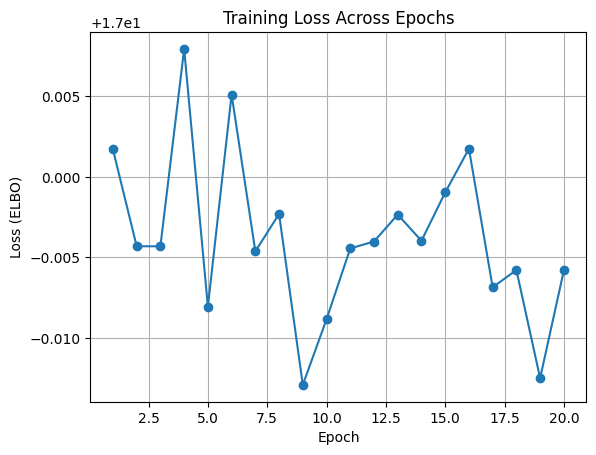

In [36]:
plt.plot(range(1, 11), loss_history, marker='o')
plt.title("Training Loss Across Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss (ELBO)")
plt.grid(True)
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       150
           1       0.12      0.19      0.15       128
           2       0.07      0.06      0.06       154
           3       0.15      0.37      0.21       142
           4       0.00      0.00      0.00       126

    accuracy                           0.12       700
   macro avg       0.07      0.12      0.08       700
weighted avg       0.07      0.12      0.08       700



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


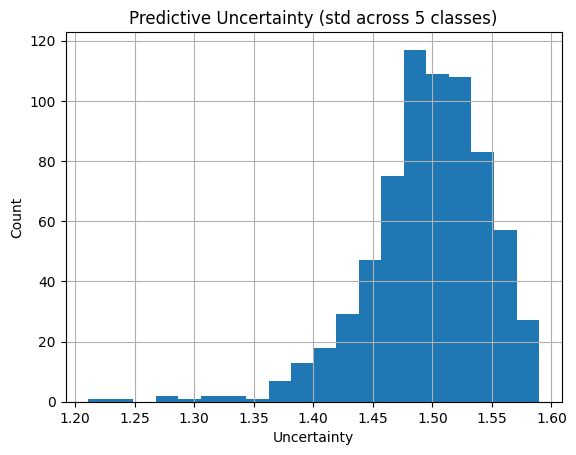

In [38]:
from sklearn.metrics import classification_report, confusion_matrix
# Run evaluation
enable_mc_dropout(model_new)
preds, true_labels, uncertainties = evaluate_model(model_new, val_tune_loader, max_samples=1000)

# Classification report
print("Classification Report:")
print(classification_report(true_labels, preds))

# Uncertainty histogram
plt.hist(uncertainties, bins=20)
plt.title("Predictive Uncertainty (std across 5 classes)")
plt.xlabel("Uncertainty")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# Optional: DataFrame for further analysis
df_eval1 = pd.DataFrame({
    'true': true_labels,
    'pred': preds,
    'uncertainty': uncertainties
})
df_eval1['correct'] = (df_eval1['true'] == df_eval1['pred']).astype(int)

In [39]:
df_eval1.head()

,true,pred,uncertainty,correct
0,2,1,1.456646,0
1,4,3,1.490315,0
2,1,3,1.528824,0
3,0,1,1.468833,0
4,1,2,1.453238,0


In [40]:
df = df_eval1.copy()
misclassified_df = df[df['correct'] == False].copy()
print("Total misclassified samples:", len(misclassified_df))
print(misclassified_df[['true', 'pred', 'uncertainty']].head())
print("Average uncertainty of misclassified samples:", misclassified_df['uncertainty'].mean())
print("Max uncertainty of misclassified samples:", misclassified_df['uncertainty'].max())

Total misclassified samples: 614
   true  pred  uncertainty
0     2     1     1.456646
1     4     3     1.490315
2     1     3     1.528824
3     0     1     1.468833
4     1     2     1.453238
Average uncertainty of misclassified samples: 1.4971520456118381
Max uncertainty of misclassified samples: 1.589654803276062


### TRAINING MODEL 2

In [124]:
loss_history = []

for epoch in range(1, 6):  # or more if needed
    train(model_new1, train_loader, optimizer, epoch, loss_history)

Epoch 1 | Avg Loss: 203.4136
Epoch 2 | Avg Loss: 203.4200
Epoch 3 | Avg Loss: 203.3774
Epoch 4 | Avg Loss: 203.3982
Epoch 5 | Avg Loss: 203.4267


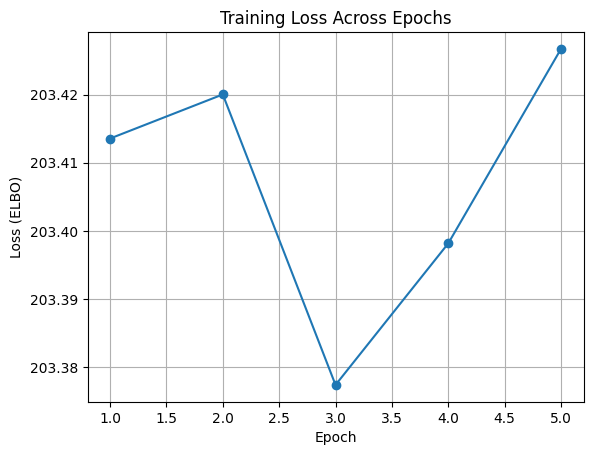

In [125]:
plt.plot(range(1, 6), loss_history, marker='o')
plt.title("Training Loss Across Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss (ELBO)")
plt.grid(True)
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       101
           1       0.00      0.00      0.00       101
           2       0.30      0.18      0.23        93
           3       0.00      0.00      0.00       103
           4       0.21      0.93      0.35       102

    accuracy                           0.22       500
   macro avg       0.10      0.22      0.12       500
weighted avg       0.10      0.22      0.11       500



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



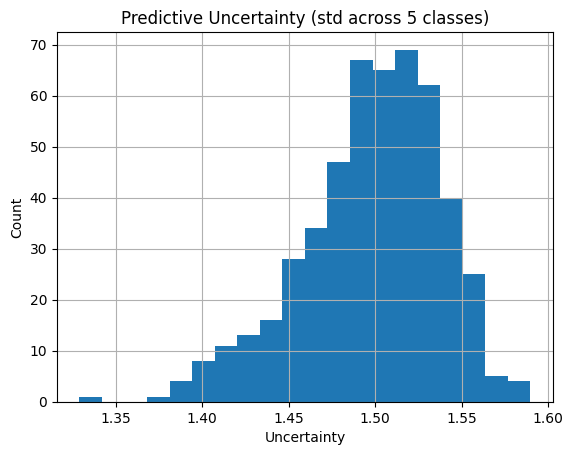

In [126]:
# Run evaluation
enable_mc_dropout(model_new1)
preds, true_labels, uncertainties = evaluate_model(model_new1, val_tune_loader, max_samples=500)

# Classification report
print("Classification Report:")
print(classification_report(true_labels, preds))

# Uncertainty histogram
plt.hist(uncertainties, bins=20)
plt.title("Predictive Uncertainty (std across 5 classes)")
plt.xlabel("Uncertainty")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# Optional: DataFrame for further analysis
df_eval2 = pd.DataFrame({
    'true': true_labels,
    'pred': preds,
    'uncertainty': uncertainties
})
df_eval2['correct'] = (df_eval2['true'] == df_eval2['pred']).astype(int)

In [127]:
df_eval2.head()

,true,pred,uncertainty,correct
0,0,4,1.435927,0
1,3,4,1.525602,0
2,2,4,1.498134,0
3,0,4,1.499624,0
4,2,4,1.495428,0


In [128]:
df = df_eval2.copy()
misclassified_df = df[df['correct'] == False].copy()
print("Total misclassified samples:", len(misclassified_df))
print(misclassified_df[['true', 'pred', 'uncertainty']].head())
print("Average uncertainty of misclassified samples:", misclassified_df['uncertainty'].mean())
print("Max uncertainty of misclassified samples:", misclassified_df['uncertainty'].max())

Total misclassified samples: 388
   true  pred  uncertainty
0     0     4     1.435927
1     3     4     1.525602
2     2     4     1.498134
3     0     4     1.499624
4     2     4     1.495428
Average uncertainty of misclassified samples: 1.4984454064025092
Max uncertainty of misclassified samples: 1.5868935585021973


### TRAINING MODEL 3

In [61]:
loss_history = []

for epoch in range(1, 21):  # or more if needed
    train(model_mc, train_loader, optimizer, epoch, loss_history)

Epoch 1 | Avg Loss: 14.9710
Epoch 2 | Avg Loss: 14.7921
Epoch 3 | Avg Loss: 14.6350
Epoch 4 | Avg Loss: 14.5015
Epoch 5 | Avg Loss: 14.3816
Epoch 6 | Avg Loss: 14.2865
Epoch 7 | Avg Loss: 14.1811
Epoch 8 | Avg Loss: 14.0990
Epoch 9 | Avg Loss: 14.0281
Epoch 10 | Avg Loss: 13.9659
Epoch 11 | Avg Loss: 13.9064
Epoch 12 | Avg Loss: 13.8584
Epoch 13 | Avg Loss: 13.8016
Epoch 14 | Avg Loss: 13.7585
Epoch 15 | Avg Loss: 13.7138
Epoch 16 | Avg Loss: 13.6754
Epoch 17 | Avg Loss: 13.6249
Epoch 18 | Avg Loss: 13.5944
Epoch 19 | Avg Loss: 13.5571
Epoch 20 | Avg Loss: 13.5178


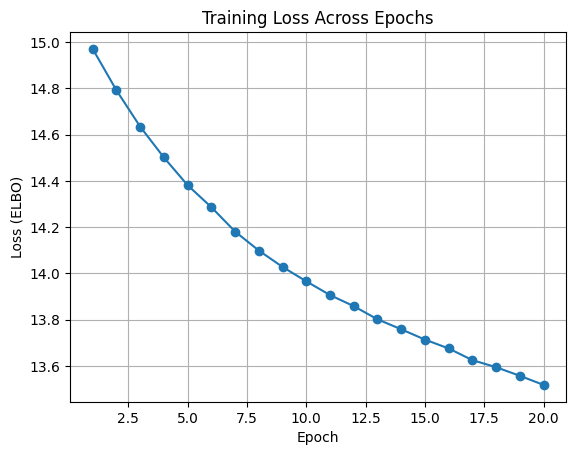

In [62]:
plt.plot(range(1, 21), loss_history, marker='o')
plt.title("Training Loss Across Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss (ELBO)")
plt.grid(True)
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       141
           1       0.80      0.87      0.83       141
           2       0.65      0.78      0.71       136
           3       0.99      0.71      0.83       142
           4       0.97      0.87      0.92       140

    accuracy                           0.84       700
   macro avg       0.86      0.84      0.84       700
weighted avg       0.86      0.84      0.84       700



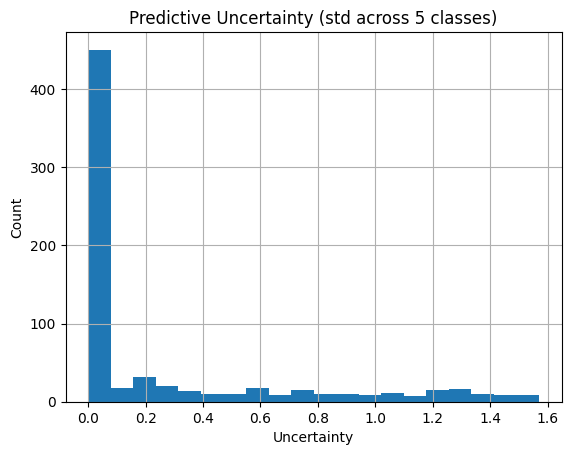

In [63]:
from sklearn.metrics import classification_report, confusion_matrix
# Run evaluation
enable_mc_dropout(model_mc)
preds, true_labels, uncertainties = evaluate_model(model_mc, val_tune_loader, max_samples=1000)

# Classification report
print("Classification Report:")
print(classification_report(true_labels, preds))

# Uncertainty histogram
plt.hist(uncertainties, bins=20)
plt.title("Predictive Uncertainty (std across 5 classes)")
plt.xlabel("Uncertainty")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# Optional: DataFrame for further analysis
df_eval3 = pd.DataFrame({
    'true': true_labels,
    'pred': preds,
    'uncertainty': uncertainties
})
df_eval3['correct'] = (df_eval3['true'] == df_eval3['pred']).astype(int)

In [64]:
df_eval3.head()

,true,pred,uncertainty,correct
0,0,0,1.527067e-01,1
1,3,2,1.255373e+00,0
2,2,0,2.762636e-02,0
3,0,0,1.377323e-10,1
4,2,2,1.326718e+00,1


In [65]:
df = df_eval3.copy()
misclassified_df = df[df['correct'] == False].copy()
print("Total misclassified samples:", len(misclassified_df))
print(misclassified_df[['true', 'pred', 'uncertainty']].head())
print("Average uncertainty of misclassified samples:", misclassified_df['uncertainty'].mean())
print("Max uncertainty of misclassified samples:", misclassified_df['uncertainty'].max())

Total misclassified samples: 112
    true  pred  uncertainty
1      3     2     1.255373
2      2     0     0.027626
7      2     1     0.774372
14     3     2     0.841454
18     2     1     1.411597
Average uncertainty of misclassified samples: 0.8153413175688391
Max uncertainty of misclassified samples: 1.5704822540283203


### TRAINING MODEL 4

In [118]:
loss_history = []

for epoch in range(1, 11):  # or more if needed
    train(model_2_5, train_loader, optimizer, epoch, loss_history)

Epoch 1 | Avg Loss: 202.7567
Epoch 2 | Avg Loss: 202.7304
Epoch 3 | Avg Loss: 202.7373
Epoch 4 | Avg Loss: 202.7442
Epoch 5 | Avg Loss: 202.7329
Epoch 6 | Avg Loss: 202.7235
Epoch 7 | Avg Loss: 202.7321
Epoch 8 | Avg Loss: 202.7276
Epoch 9 | Avg Loss: 202.7391
Epoch 10 | Avg Loss: 202.7185


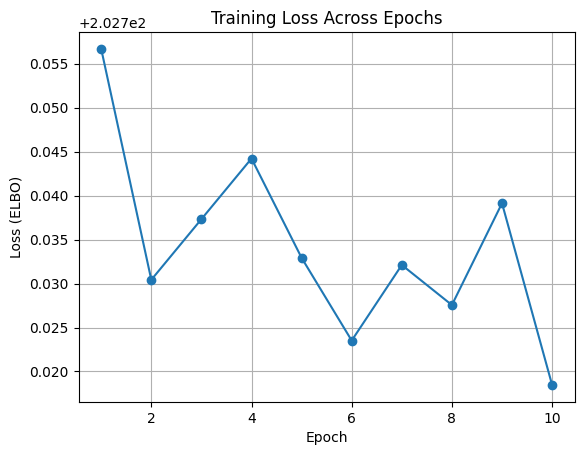

In [119]:

plt.plot(range(1, 11), loss_history, marker='o')
plt.title("Training Loss Across Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss (ELBO)")
plt.grid(True)
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.10      0.20      0.14       101
           1       0.12      0.26      0.16       101
           2       0.00      0.00      0.00        93
           3       0.00      0.00      0.00       103
           4       0.36      0.30      0.33       102

    accuracy                           0.15       500
   macro avg       0.12      0.15      0.13       500
weighted avg       0.12      0.15      0.13       500



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



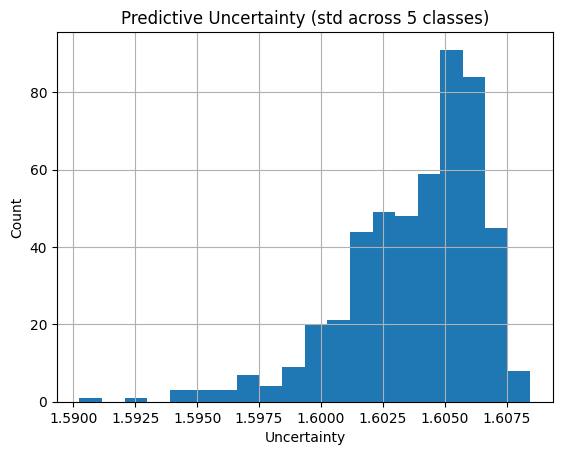

In [120]:
# Run evaluation
enable_mc_dropout(model_2_5)
preds, true_labels, uncertainties = evaluate_model(model_2_5, val_tune_loader, max_samples=500)

# Classification report
print("Classification Report:")
print(classification_report(true_labels, preds))

# Uncertainty histogram
plt.hist(uncertainties, bins=20)
plt.title("Predictive Uncertainty (std across 5 classes)")
plt.xlabel("Uncertainty")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# Optional: DataFrame for further analysis
df_eval4 = pd.DataFrame({
    'true': true_labels,
    'pred': preds,
    'uncertainty': uncertainties
})
df_eval4['correct'] = (df_eval4['true'] == df_eval4['pred']).astype(int)

In [121]:
df_eval4.head()

,true,pred,uncertainty,correct
0,0,1,1.606790,0
1,3,4,1.602703,0
2,2,0,1.601307,0
3,0,1,1.598074,0
4,2,0,1.606862,0


In [122]:
df = df_eval4.copy()
misclassified_df = df[df['correct'] == False].copy()
print("Total misclassified samples:", len(misclassified_df))
print(misclassified_df[['true', 'pred', 'uncertainty']].head())
print("Average uncertainty of misclassified samples:", misclassified_df['uncertainty'].mean())
print("Max uncertainty of misclassified samples:", misclassified_df['uncertainty'].max())

Total misclassified samples: 423
   true  pred  uncertainty
0     0     1     1.606790
1     3     4     1.602703
2     2     0     1.601307
3     0     1     1.598074
4     2     0     1.606862
Average uncertainty of misclassified samples: 1.603815788918353
Max uncertainty of misclassified samples: 1.60845947265625


## INFERENCE

### CHOOSING MODEL 3 FOR INFERENCE

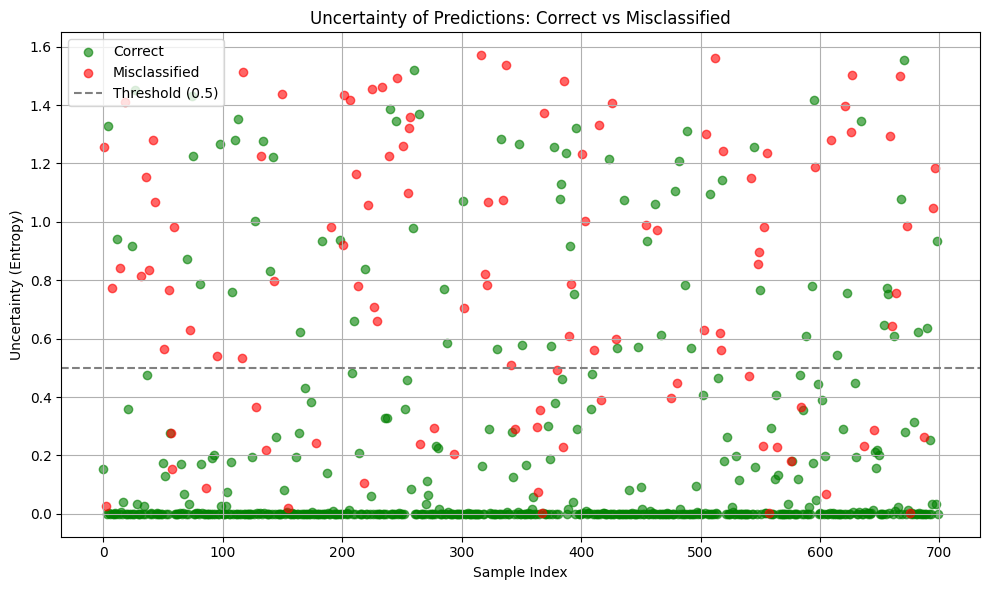

In [130]:
df = df_eval3.copy()
df['correct'] = (df['true'] == df['pred']).astype(bool)

plt.figure(figsize=(10, 6))

# Correct predictions (green)
plt.scatter(
    df[df['correct']].index,
    df[df['correct']]['uncertainty'],
    color='green', label='Correct', alpha=0.6
)

# Misclassified predictions (red)
plt.scatter(
    df[~df['correct']].index,
    df[~df['correct']]['uncertainty'],
    color='red', label='Misclassified', alpha=0.6
)

plt.axhline(y=0.5, color='gray', linestyle='--', label='Threshold (0.5)')
plt.xlabel("Sample Index")
plt.ylabel("Uncertainty (Entropy)")
plt.title("Uncertainty of Predictions: Correct vs Misclassified")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [131]:
import plotly.express as px
import plotly.graph_objects as go
df['index'] = df.index
df['result'] = df['correct'].map({True: 'Correct', False: 'Misclassified'})
df['true'] = df['true'].astype(str)

# Unique class labels
classes = sorted(df['true'].unique())

# Create traces
traces = []
for cls in classes:
    for result in ['Correct', 'Misclassified']:
        filtered = df[(df['true'] == cls) & (df['result'] == result)]
        trace = go.Scatter(
            x=filtered['index'],
            y=filtered['uncertainty'],
            mode='markers',
            name=f"{result} - Class {cls}",
            marker=dict(color='green' if result == 'Correct' else 'red'),
            visible=True  # will manage visibility with dropdown
        )
        traces.append(trace)

# Create dropdown visibility toggles
dropdown_buttons = []

# "All classes"
dropdown_buttons.append(dict(
    method="update",
    label="All Classes",
    args=[{"visible": [True] * len(traces)},
          {"title": "Uncertainty of Predictions - All Classes"}]
))

# One button per class
for i, cls in enumerate(classes):
    visible = [False] * len(traces)
    visible[2 * i] = True       # Correct trace for class i
    visible[2 * i + 1] = True   # Misclassified trace for class i
    dropdown_buttons.append(dict(
        method="update",
        label=f"Class {cls}",
        args=[{"visible": visible},
              {"title": f"Uncertainty of Predictions - Class {cls}"}]
    ))

# Build the figure
fig = go.Figure(data=traces)

# Add threshold line
fig.add_hline(
    y=0.5,
    line_dash="dash",
    line_color="gray",
    annotation_text="Threshold = 0.5",
    annotation_position="top left"
)

# Update layout
fig.update_layout(
    title="Uncertainty of Predictions - All Classes",
    xaxis_title="Sample Index",
    yaxis_title="Uncertainty (Mean Softmax Std)",
    updatemenus=[dict(
        active=0,
        buttons=dropdown_buttons,
        direction="down",
        showactive=True,
        x=1.05,
        xanchor="left",
        y=1.15,
        yanchor="top"
    )],
    legend_title="",
    template="plotly_white",
    height=600
)
fig.write_html("uncertainty_plot_class_wise.html")
fig.show()

In [13]:
from IPython.display import IFrame

IFrame("uncertainty_plot_class_wise.html", width=1150, height=600)

### LOOKING AT THE ENTROPY PER CLASS

In [80]:
df_entropy = pd.DataFrame({
    'true': true_labels,
    'pred': preds,
    'entropy': uncertainties
})

df_entropy['true'] = df_entropy['true'].astype(str)

In [132]:
import plotly.express as px

fig = px.histogram(
    df_entropy,
    x="entropy",
    color="true",
    facet_col="true",
    facet_col_wrap=3,
    nbins=30,
    title="Entropy Distribution per True Class",
    labels={"entropy": "Predictive Entropy"},
    color_discrete_sequence=px.colors.qualitative.Set1
)
fig.update_layout(showlegend=False, height=600, template="plotly_white")
fig.write_html("uncertainty_entropy.html")
fig.show()

In [5]:
from IPython.display import IFrame

IFrame("uncertainty_entropy.html", width=1000, height=600)

## PREDICTING WITH IDK

In [111]:
df=df_eval3.copy()
df['idk'] = df['uncertainty'] > 0.5

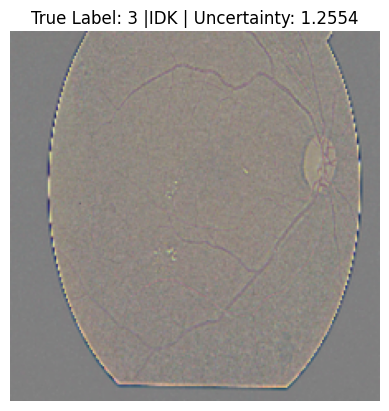

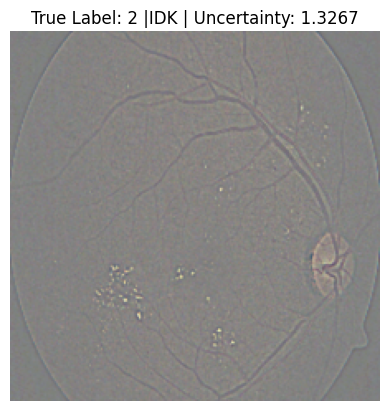

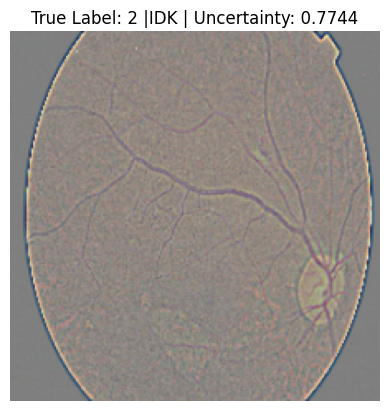

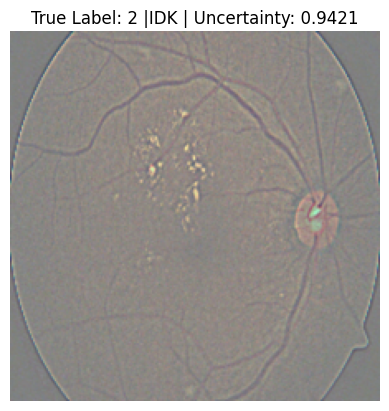

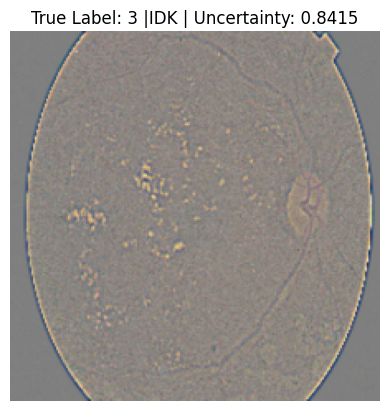

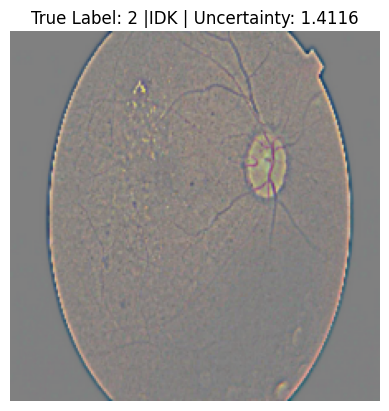

In [112]:
idk_indices = df[df['idk'] == True].index.tolist()


for idx in idk_indices[:6]:
    img = images_list[idx]
    true = df.loc[idx, 'true']
    uncertainty = df.loc[idx, 'uncertainty']

    plt.imshow(img.permute(1, 2, 0))
    plt.title(f"True Label: {true} |IDK | Uncertainty: {uncertainty:.4f}")
    plt.axis("off")
    plt.show()


In [113]:
df.head()

,true,pred,uncertainty,correct,idk
0,0,0,1.527067e-01,1,False
1,3,2,1.255373e+00,0,True
2,2,0,2.762636e-02,0,False
3,0,0,1.377323e-10,1,False
4,2,2,1.326718e+00,1,True


In [114]:
# Filter confident predictions
confident_df = df[df['idk'] == False].copy()
confident_df['correct'] = confident_df['true'] == confident_df['pred']

accuracy_confident = confident_df['correct'].mean()
coverage = len(confident_df) / len(df)

print(f"Accuracy on confident predictions: {accuracy_confident:.2%}")
print(f"Coverage (not referred): {coverage:.2%}")
print(f"IDK (referred to expert): {1 - coverage:.2%}")

Accuracy on confident predictions: 93.99%
Coverage (not referred): 78.43%
IDK (referred to expert): 21.57%


### FINE-TUNING THE THRESHOLDS

In [96]:
# Ensure 'true' is int if needed
df_entropy['true'] = df_entropy['true'].astype(int)

# Automatically compute 80th percentile per class
class_entropy_thresholds = df_entropy.groupby('true')['entropy'].quantile(0.8).to_dict()

# Print thresholds for inspection
print("Class-wise entropy thresholds (80th percentile):")
for cls, threshold in class_entropy_thresholds.items():
    print(f"Class {cls}: {threshold:.4f}")

Class-wise entropy thresholds (80th percentile):
Class 0: 0.0238
Class 1: 0.7656
Class 2: 1.0623
Class 3: 0.5011
Class 4: 0.0001


In [97]:
df_eval = pd.DataFrame({
    'true': true_labels,
    'pred': preds,
    'entropy': uncertainties
})

In [98]:
strategy = {
    0: "min_fp",
    1: "min_fp",
    2: "hybrid_fp_f1",
    3: "strict_tp_entropy",
    4: "strict_tp_entropy"
}


best_thresholds = choose_thresholds_by_strategy(df_eval, strategy)

Class 0 → Strategy: min_fp → Chosen Threshold: 0.1000 | TP: 137.0 | FP: 20.0 | F1: 0.919
Class 1 → Strategy: min_fp → Chosen Threshold: 0.1000 | TP: 122.0 | FP: 31.0 | F1: 0.830
Class 2 → Strategy: hybrid_fp_f1 → Chosen Threshold: 0.1000 | TP: 106.0 | FP: 56.0 | F1: 0.711
Class 3 → Strategy: strict_tp_entropy → Chosen Threshold: 0.1000 | TP: 101.0 | FP: 1.0 | F1: 0.828
Class 4 → Strategy: strict_tp_entropy → Chosen Threshold: 0.1000 | TP: 122.0 | FP: 4.0 | F1: 0.917


In [103]:
preds, true_labels, entropies, idk_flags, images = get_val_predictions_with_idk_and_images_class(model_mc, val_holdout_loader, class_entropy_thresholds=best_thresholds, max_samples=1000 )

In [104]:
import pandas as pd

df_eval = pd.DataFrame({
    "true": true_labels,
    "pred": preds,
    "entropy": entropies,
    "idk": idk_flags
})

# Filter out IDKs
df_filtered = df_eval[df_eval["idk"] == False].copy()
df_filtered["correct"] = df_filtered["true"] == df_filtered["pred"]

In [105]:
total = len(df_eval)
predicted = len(df_filtered)
coverage = predicted / total

accuracy = df_filtered["correct"].mean()

print(f"Total samples: {total}")
print(f"Predicted (not IDK): {predicted} → Coverage: {coverage:.2%}")
print(f"Accuracy on predicted samples: {accuracy:.2%}")

Total samples: 301
Predicted (not IDK): 183 → Coverage: 60.80%
Accuracy on predicted samples: 98.36%


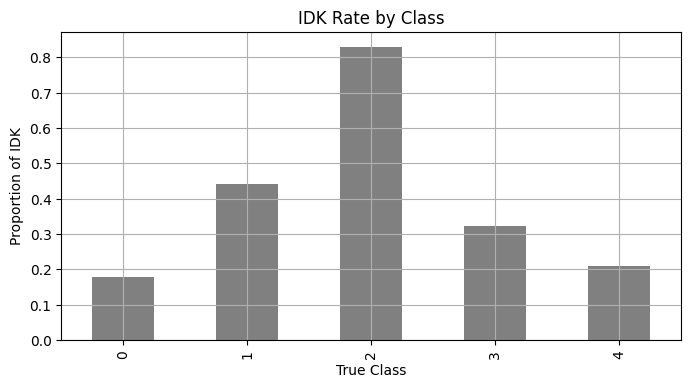

In [106]:
df_eval["idk"] = df_eval["pred"] == "IDK"
idk_rate_by_class = df_eval.groupby("true")["idk"].mean()

plt.figure(figsize=(8, 4))
idk_rate_by_class.plot(kind="bar", color="gray")
plt.title("IDK Rate by Class")
plt.ylabel("Proportion of IDK")
plt.xlabel("True Class")
plt.grid(True)
plt.show()

In [107]:
df = pd.DataFrame({
    "true": true_labels,
    "pred": preds,
    "idk": idk_flags
})

# Only keep predictions that are not "IDK"
df_eval = df[df["pred"] != "IDK"].copy()
df_eval["true"] = df_eval["true"].astype(int)
df_eval["pred"] = df_eval["pred"].astype(int)

from sklearn.metrics import classification_report

print("Classification Report (Excludes IDK):")
print(classification_report(
    df_eval["true"],
    df_eval["pred"],
    labels=[0, 1, 2, 3, 4],
    target_names=["Healthy", "Mild", "Moderate", "Severe", "Proliferative"],
    digits=3
))


Classification Report (Excludes IDK):
               precision    recall  f1-score   support

      Healthy      0.944     1.000     0.971        51
         Mild      1.000     1.000     1.000        33
     Moderate      1.000     0.800     0.889        10
       Severe      1.000     0.975     0.987        40
Proliferative      1.000     1.000     1.000        49

     accuracy                          0.984       183
    macro avg      0.989     0.955     0.970       183
 weighted avg      0.985     0.984     0.983       183



In [108]:
confident_df = df[df['idk'] == False].copy()
confident_df['correct'] = confident_df['true'] == confident_df['pred']

accuracy_confident = confident_df['correct'].mean()
coverage = len(confident_df) / len(df)

print(f"Accuracy on confident predictions: {accuracy_confident:.2%}")
print(f"Coverage (not referred): {coverage:.2%}")
print(f"IDK (referred to expert): {1 - coverage:.2%}")

Accuracy on confident predictions: 98.36%
Coverage (not referred): 60.80%
IDK (referred to expert): 39.20%
